# Risk of death due to circulatory causes in 7 years

We would like you to:

- Create a prototype model estimating the risk of death due to circulatory causes within 7 years, using python
- Detail the approach you have taken
- Visualise the output of the model using an appropriate format
- Explain model selection and justification as to why this was chosen over other approaches
- Success criteria
- Highlight any current limitations in the model
- Discuss subsequent next steps

### Load packages and dataset

In [49]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sn
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

In [5]:
cd

/Users/jessicairving


In [6]:
df = pd.read_csv('ml-interview-task-main/five_lives_ml_task_data.csv')

### Exploratory data analysis

We can see that: 
- **Age:** no outlandish ages, however missing data, 100% correlated with having no creatinine value. This is going to be an incredibly important variable, so we'll explore the pattern of missingness around it
- **Chapter:** only recorded if outcome is experienced so not appropriate for a prognostic model. However we can use this to formulate a variable recording circulatory death and evaluate competing risks of deaths from other causes
- **Creatinine** = missing data
- **Futime:** Some people followed for 14 years - what's going on?

In [9]:
df.head()

,age,chapter,creatinine,flc.grp,kappa,lambda,mgus,sample.yr,sex,death,futime
0,97.0,Circulatory,1.7,10,5.70,4.860,no,1997,F,True,85.0
1,92.0,Neoplasms,0.9,1,0.87,0.683,no,2000,F,True,1281.0
2,94.0,Circulatory,1.4,10,4.36,3.850,no,1997,F,True,69.0
3,92.0,Circulatory,1.0,9,2.42,2.220,no,1996,F,True,115.0
4,93.0,Circulatory,1.1,6,1.32,1.690,no,1996,F,True,1039.0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7874 entries, 0 to 7873
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   age         6524 non-null   float64 
 1   chapter     2169 non-null   object  
 2   creatinine  6524 non-null   float64 
 3   flc.grp     7874 non-null   int64   
 4   kappa       7874 non-null   float64 
 5   lambda      7874 non-null   float64 
 6   mgus        7874 non-null   category
 7   sample.yr   7874 non-null   float64 
 8   sex         7874 non-null   category
 9   death       7874 non-null   bool    
 10  futime      7874 non-null   float64 
 11  circ_death  7874 non-null   bool    
dtypes: bool(2), category(2), float64(6), int64(1), object(1)
memory usage: 523.2+ KB


In [10]:
df['flc.grp'].value_counts()

3     820
2     811
7     806
9     803
6     791
5     791
4     786
1     769
10    767
8     730
Name: flc.grp, dtype: int64

In [12]:
df.describe(include = 'all') # 2169 events.

,age,chapter,creatinine,flc.grp,kappa,lambda,mgus,sample.yr,sex,death,futime
count,6524.000000,2169,6524.000000,7874.000000,7874.000000,7874.000000,7874,7874.000000,7874,7874,7874.000000
unique,NaN,16,NaN,NaN,NaN,NaN,2,NaN,2,2,NaN
top,NaN,Circulatory,NaN,NaN,NaN,NaN,no,NaN,F,False,NaN
freq,NaN,745,NaN,NaN,NaN,NaN,7759,NaN,4350,5705,NaN
mean,65.057787,NaN,1.093516,5.470536,1.430881,1.702624,NaN,1996.790831,NaN,NaN,3661.042291
std,10.682585,NaN,0.416507,2.863011,0.896774,1.030732,NaN,1.765156,NaN,NaN,1432.677330
min,50.000000,NaN,0.400000,1.000000,0.010000,0.040000,NaN,1995.000000,NaN,NaN,0.000000
25%,56.000000,NaN,0.900000,3.000000,0.960000,1.200000,NaN,1996.000000,NaN,NaN,2852.000000
50%,63.500000,NaN,1.000000,5.000000,1.270000,1.510000,NaN,1996.000000,NaN,NaN,4302.000000
75%,73.000000,NaN,1.200000,8.000000,1.680000,1.920000,NaN,1997.000000,NaN,NaN,4773.000000


In [13]:
df.mgus.value_counts()

no     7759
yes     115
Name: mgus, dtype: int64

['Circulatory', 'Neoplasms', 'Mental', 'Nervous', 'Respiratory', 'Digestive', 'Injury and Poisoning', 'External Causes', 'Genitourinary', 'Ill Defined', 'Infectious', 'Blood', 'Endocrine', 'Musculoskeletal', 'Skin', 'Congenital']


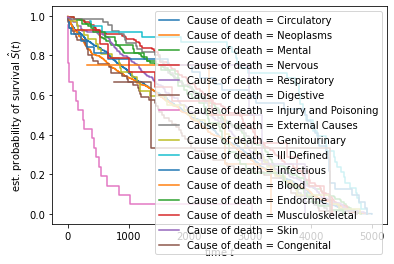

In [38]:
chapter = df.chapter.unique()
chapter = [x for x in chapter if pd.isnull(x) == False]
print(chapter)

for treatment_type in (chapter):
    mask_treat = df["chapter"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        df["death"][mask_treat],
        df["futime"][mask_treat])

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Cause of death = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [15]:
df.death.value_counts()

False    5705
True     2169
Name: death, dtype: int64

In [16]:
df['sample.yr'].value_counts() # Vast majority recruited in late 90s. 

1996.0    3491
1997.0    1381
1995.0    1275
1998.0     687
1999.0     350
2000.0     245
2003.0     222
2001.0     175
2002.0      48
Name: sample.yr, dtype: int64

#### Correlations between features
*Kappa* and *lambda* are strongly correlated. My sense is to create a new variable of their sum, which we know is informative given flc.grp, and also create a new variable called flc.ratio representing the ratio between the two. It will be important to then check the correlation between these two. 

From the paper and from plotting I can see that flc.grp is just the sum of kappa and lambda together, binned into deciles. I want to get rid of these arbitrary bins and return this value to its raw form, which is better practice.

In [53]:
df.corr()

,age,creatinine,flc.grp,kappa,lambda,sample.yr,death,futime,circ_death
age,1.000000,0.116439,0.317990,0.279997,0.229881,-0.125051,0.539427,-0.405917,0.345834
creatinine,0.116439,1.000000,0.259453,0.553277,0.502504,0.043304,0.157080,-0.190837,0.126660
flc.grp,0.317990,0.259453,1.000000,0.703849,0.653835,0.072409,0.279271,-0.284912,0.183771
kappa,0.279997,0.553277,0.703849,1.000000,0.819552,0.076069,0.284790,-0.324305,0.185008
lambda,0.229881,0.502504,0.653835,0.819552,1.000000,0.002739,0.256982,-0.279041,0.152651
sample.yr,-0.125051,0.043304,0.072409,0.076069,0.002739,1.000000,-0.121811,-0.315571,-0.086331
death,0.539427,0.157080,0.279271,0.284790,0.256982,-0.121811,1.000000,-0.639805,0.524278
futime,-0.405917,-0.190837,-0.284912,-0.324305,-0.279041,-0.315571,-0.639805,1.000000,-0.358691
circ_death,0.345834,0.126660,0.183771,0.185008,0.152651,-0.086331,0.524278,-0.358691,1.000000


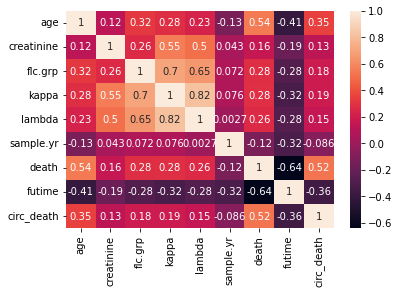

In [54]:
corrMatrix = df.corr()

sn.heatmap(corrMatrix, annot=True)
plt.show()

### Feature wrangling

In [63]:
df['kl_sum'] = df['kappa'] + df['lambda']
df['kl_ratio'] = df['kappa'] / df['lambda']

In [64]:
# Check correlations of new variables
df.corr()

,age,creatinine,flc.grp,kappa,lambda,sample.yr,death,futime,circ_death,kl_sum,kl_ratio
age,1.000000,0.116439,0.317990,0.279997,0.229881,-0.125051,0.539427,-0.405917,0.345834,0.264777,0.016453
creatinine,0.116439,1.000000,0.259453,0.553277,0.502504,0.043304,0.157080,-0.190837,0.126660,0.550158,0.049788
flc.grp,0.317990,0.259453,1.000000,0.703849,0.653835,0.072409,0.279271,-0.284912,0.183771,0.709715,0.028100
kappa,0.279997,0.553277,0.703849,1.000000,0.819552,0.076069,0.284790,-0.324305,0.185008,0.947021,0.144082
lambda,0.229881,0.502504,0.653835,0.819552,1.000000,0.002739,0.256982,-0.279041,0.152651,0.960166,-0.105287
sample.yr,-0.125051,0.043304,0.072409,0.076069,0.002739,1.000000,-0.121811,-0.315571,-0.086331,0.038631,0.065388
death,0.539427,0.157080,0.279271,0.284790,0.256982,-0.121811,1.000000,-0.639805,0.524278,0.282920,0.020537
futime,-0.405917,-0.190837,-0.284912,-0.324305,-0.279041,-0.315571,-0.639805,1.000000,-0.358691,-0.314554,-0.041107
circ_death,0.345834,0.126660,0.183771,0.185008,0.152651,-0.086331,0.524278,-0.358691,1.000000,0.175782,0.018044
kl_sum,0.264777,0.550158,0.709715,0.947021,0.960166,0.038631,0.282920,-0.314554,0.175782,1.000000,0.011249


In [11]:
df["sex"] = df["sex"].astype("category")
df["mgus"] = df["mgus"].astype("category")
df["sample.yr"] = df["sample.yr"].astype("float") # temporary hack 

In [17]:
# Define outcome variable
df['circ_death'] = np.where((df.death == True) & ((df.chapter == 'Circulatory')), True, False)

In [58]:
df.circ_death.value_counts() # 745 deaths from circulatory causes

False    7129
True      745
Name: circ_death, dtype: int64

##### Missing data counts
Age and creatinine are missing for the same ~17% of individuals. I'm going to use multiple imputation later on to handle these, but I'll wait until I've split the train and test sets so there is no data leakage into the test set.

In [59]:
df.isnull().sum(axis = 0)

age           1350
chapter       5705
creatinine    1350
flc.grp          0
kappa            0
lambda           0
mgus             0
sample.yr        0
sex              0
death            0
futime           0
circ_death       0
kl_sum           0
dtype: int64

### Kaplan Meier curve

The estimated curve is a step function, with steps occurring at time points where one or more patients died.

Text(0.5, 1.0, 'Survival function')

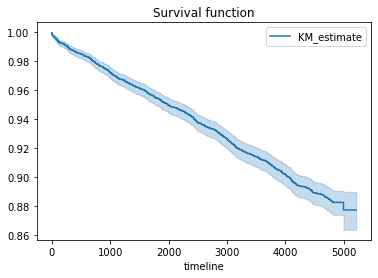

In [60]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df.futime, event_observed = df.circ_death)
kmf.plot_survival_function()
plt.title('Survival function')

In [61]:
kmf

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7874 total observations, 7129 right-censored observations>

### Multivariate Survival Model: Cox Proportional Hazards Regression

First let's split the data into derivation (train) and validation (test) sets. There are numerous ways to approach this, such as randomly splitting the data in a way that ensures equivalent class balance in each group. However, a genuine external temporal validation will be most able to show us bias. Most of the data are collected in the late 90s - I'm very interested to see how trends generalise to later years, as a good survival model should be flexible to developments in technology and sociopolitical trends regarding access to healthcare over time. It's feasible there will be many differences in healthcare (technologically, socially etc) in those years. Will they stand up?

Taking the last few years of data as our test set should allot just above 10% of the total rows of data.

#### Feature selection
Sample year is used to split our variables, so in it's raw form it might not be useful. However there MAY be a function of time - a linear relationship?

In [103]:
exclude_years = 1999, 2000, 2001, 2002, 2003

train_y = df[df["sample.yr"].isin(exclude_years) == False].filter(['circ_death', 'futime'])

train_x = df[df["sample.yr"].isin(exclude_years) == False].filter(['age','kappa', 'lambda', 'mgus', 'creatinine']) #temporarily remove age and creatinine

test_y = df[df["sample.yr"].isin(exclude_years)].drop(['chapter'], 1).filter(['circ_death', 'futime'])

test_x = df[df["sample.yr"].isin(exclude_years)].drop(['chapter'], 1).filter(['age','kappa', 'lambda', 'mgus', 'creatinine'])

/var/folders/21/ys10fbm105d1rxr4098dlw6c0000gn/T/ipykernel_6841/888438765.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_y = df[df["sample.yr"].isin(exclude_years)].drop(['chapter'], 1).filter(['circ_death', 'futime'])
/var/folders/21/ys10fbm105d1rxr4098dlw6c0000gn/T/ipykernel_6841/888438765.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_x = df[df["sample.yr"].isin(exclude_years)].drop(['chapter'], 1).filter(['age','kappa', 'lambda', 'mgus', 'creatinine'])


In [104]:
train_x.head()

,age,kappa,lambda,mgus,creatinine
0,97.0,5.70,4.86,no,1.7
2,94.0,4.36,3.85,no,1.4
3,92.0,2.42,2.22,no,1.0
4,93.0,1.32,1.69,no,1.1
5,90.0,2.01,1.86,no,1.0


##### Short hacky way of replacing missing values

In [105]:
train_x["age"].fillna(train_x["age"].median(), inplace = True) # Median as heavily right skewed
train_x["creatinine"].fillna(train_x["creatinine"].median(), inplace = True) # Median as heavily right skewed

test_x["age"].fillna(test_x["age"].median(), inplace = True) # Median as heavily right skewed
test_x["creatinine"].fillna(test_x["creatinine"].median(), inplace = True) # Median as heavily right skewed

In [106]:
from sksurv.preprocessing import OneHotEncoder

train_numeric = OneHotEncoder().fit_transform(train_x) # We convert categorical variables in the data set into numeric values.
train_numeric.head()

,age,kappa,lambda,mgus=yes,creatinine
0,97.0,5.70,4.86,0.0,1.7
2,94.0,4.36,3.85,0.0,1.4
3,92.0,2.42,2.22,0.0,1.0
4,93.0,1.32,1.69,0.0,1.1
5,90.0,2.01,1.86,0.0,1.0


In [107]:
test_numeric = OneHotEncoder().fit_transform(test_x) # We convert categorical variables in the data set into numeric values.
test_numeric.head()

,age,kappa,lambda,mgus=yes,creatinine
1,92.0,0.87,0.683,0.0,0.9
7,90.0,2.47,2.700,0.0,1.2
53,100.0,1.82,3.250,0.0,1.6
81,93.0,2.84,2.200,0.0,1.5
90,59.0,4.66,5.960,0.0,1.1


In [108]:
# Import IterativeImputer from fancyimpute
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)

imp.fit(train_numeric)

IterativeImputer(random_state=0)

In [109]:
train_numeric

,age,kappa,lambda,mgus=yes,creatinine
0,97.0,5.700,4.86,0.0,1.7
2,94.0,4.360,3.85,0.0,1.4
3,92.0,2.420,2.22,0.0,1.0
4,93.0,1.320,1.69,0.0,1.1
5,90.0,2.010,1.86,0.0,1.0
...,...,...,...,...,...
7867,53.0,0.705,1.25,0.0,0.8
7868,52.0,0.786,1.03,0.0,0.7
7869,52.0,1.210,1.61,0.0,1.0
7872,64.0,1.710,2.69,0.0,1.0


In [110]:
test_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 1 to 7871
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1040 non-null   float64
 1   kappa       1040 non-null   float64
 2   lambda      1040 non-null   float64
 3   mgus=yes    1040 non-null   float64
 4   creatinine  1040 non-null   float64
dtypes: float64(5)
memory usage: 48.8 KB


To correctly apply iterative missing data imputation and avoid data leakage, it is required that the models for each column are calculated on the training dataset only, then applied to the train and test sets for each fold in the dataset.

This can be achieved by creating a modeling pipeline where the first step is the iterative imputation, then the second step is the model. This can be achieved using the Pipeline class.

In [111]:
from sksurv.util import Surv

train_y = Surv.from_dataframe("circ_death", "futime", train_y)
test_y = Surv.from_dataframe("circ_death", "futime", test_y)

In [112]:
from sksurv.linear_model import CoxPHSurvivalAnalysis


estimator = CoxPHSurvivalAnalysis()
estimator.fit(train_numeric, train_y)

CoxPHSurvivalAnalysis()

In [113]:
pd.Series(estimator.coef_, index= train_numeric.columns)

age           0.121320
kappa         0.122013
lambda        0.137301
mgus=yes      0.097603
creatinine    0.055709
dtype: float64

In [114]:
pred_surv = estimator.predict_survival_function(test_numeric)

## Success criteria / measuring performance

We use generalization of the area under the receiver operating characteristic (ROC) curve called Harrell’s concordance index or c-index.

The interpretation is identical to the traditional area under the ROC curve metric for binary classification: - a value of 0.5 denotes a random model, - a value of 1.0 denotes a perfect model, - a value of 0.0 denotes a perfectly wrong model.



Validation options
Table 3 lays out seven suggestions for external validation of models for time to event data. These are discussed individually below. The column headed ‘Aspect’ indicates whether a given method addresses the discrimination (D), calibration (C) or more general fit (F) of a model.

#### Harrell's C - a note
Harrell’s concordance index is known to be biased upwards if the amount of censoring in the test data is high. There is huge censoring for the outcome of death from a circulatory disease and therefore Harrell'C is not appropriate. it is not a useful measure of performance if a specific time range is of primary interest (e.g. predicting death within 2 years). 

In this case we'll use time dependent ROC.

#### Cumlative dynamic AUC

In [115]:
from sklearn.pipeline import make_pipeline

cph = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
cph.fit(train_numeric, train_y)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('coxphsurvivalanalysis', CoxPHSurvivalAnalysis())])

In [ ]:
The plot shows that our model performs 

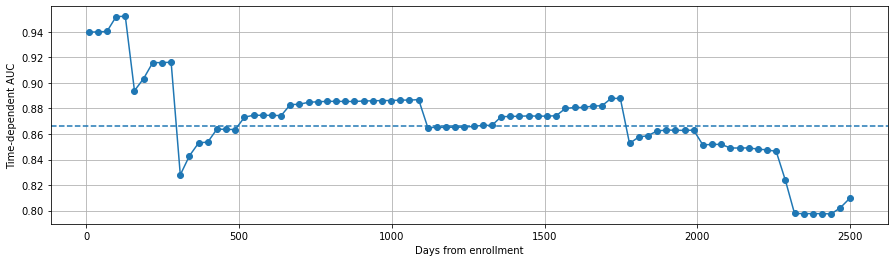

In [122]:
va_times = np.arange(8, 2520, 30) # Weekly intervals from the first week, for 7 years

cph_risk_scores = cph.predict(test_numeric)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
    train_y, test_y, cph_risk_scores, va_times
)

plt.rcParams["figure.figsize"] = (15,4)


plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("Days from enrollment")
plt.ylabel("Time-dependent AUC")
plt.grid(True)

In [79]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
# Internal validation
prediction = estimator.predict(train_numeric)
result = concordance_index_ipcw(train_y["circ_death"], train_y["futime"], prediction)
print('Harrell\'s C = ' + str(result[0]))

ValueError: y must be a structured array with the first field being a binary class event indicator and the second field the time of the event/censoring

In [101]:
# External validation - performs better? 

prediction = estimator.predict(test_numeric)
result = concordance_index_censored(test_y["circ_death"], test_y["futime"], prediction)
print('Harrell\'s C = ' + str(result[0]))

Harrell's C = 0.8237036176760931


Harrell’s concordance index is known to be biased upwards if the amount of censoring in the test data is high. This might be why it's higher in external validation. 2. it is not a useful measure of performance if a specific time range is of primary interest (e.g. predicting death within 2 years). Let's see what 

### Competing risks: When subjects have multiple possible events in a time-to-event setting

Examples:

recurrence
death from disease
death from other causes
treatment response
All or some of these (among others) may be possible events in any given study.

So what’s the problem?
Unobserved dependence among event times is the fundamental problem that leads to the need for special consideration.

For example, one can imagine that patients who recur are more likely to die, and therefore times to recurrence and times to death would not be independent events.

Cumulative incidence using Kaplan-Meier is always >= cumulative incidence using competing risks methods, so can only lead to an overestimate of the cumulative incidence, the amount of overestimation depends on event rates and dependence among events

A bunch of additional notes and references
When the events are independent (almost never true), cause-specific hazards is unbiased
When the events are dependent, a variety of results can be obtained depending on the setting

### Competing risks regression

https://www.emilyzabor.com/tutorials/survival_analysis_in_r_tutorial.html

Two approaches:

Cause-specific hazards
instantaneous rate of occurrence of the given type of event in subjects who are currently event‐free
estimated using Cox regression (coxph function)
Subdistribution hazards
instantaneous rate of occurrence of the given type of event in subjects who have not yet experienced an event of that type
estimated using Fine-Gray regression (crr function)

Competing risks regression in Melanoma data - subdistribution hazard approach
Let’s say we’re interested in looking at the effect of age and sex on death from melanoma, with death from other causes as a competing event.

Notes:

crr requires specification of covariates as a matrix
If more than one event is of interest, you can request results for a different event by using the failcode option, by default results are returned for failcode = 1

### Prognostic index
https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/1471-2288-13-33#Sec2

For practical application, the main product of a Cox model is a prognostic index (PI). The variables which comprise the PI may have been selected by a multivariable modelling technique that automatically takes into account correlations among variables, such as stepwise selection from a list of candidate variables. This approach often removes apparently redundant predictors. Some of the variables included in a PI may be continuous, and some may be transformed (as with the MFP method, or when using regression splines [20]). There is no necessity to dichotomise continuous variables—indeed, it wastes information [21].

The obvious way to construct a PI is to take the linear predictor from a Cox model. The linear predictor is a weighted sum of the variables in the model, where the weights are the regression coefficients. In the usual situation in which the event of interest is an adverse outcome, high values indicate a worse prognosis. The PI for an individual is then the log relative hazard compared with a hypothetical individual whose PI is zero.

Regardless of the justification for any post hoc manipulation, the approach to validation of a model is the same, no matter how a PI was obtained. It is, however, worth mentioning some factors that increase the likelihood of poor performance in a validation study: stepwise selection of variables from a large number of candidate variables with a small number of events, data-dependent cutpoint selection for continuous predictors, extensive missing data, a differently defined endpoint. In cancer, for example, the endpoint could be overall survival in the derivation dataset and progression-free survival in the validation dataset.

#### Risk groups
Mainly for clinical and statistical reasons, a PI is often used to create risk groups. The statistical reason is that it facilitates the comparison of actual survival probabilites with model-based estimates. Kaplan-Meier curves for each risk group offer an intuitive depiction of variation in prognosis. The disadvantage of grouping is that associated with any categorisation of a continuous variable [21]: information is lost, particularly at extreme risks. An alternative approach is to derive survival curves directly from the Cox model; a comparison with the Kaplan-Meier curves gives one possible assessment of the model calibration.

### Issues to delve into / future avenues for investigation

**Left censoring:** this population only starts at age 50 and individuals don't enter at the same time, so potentially they might have died in this period

**Data leakage from multiple imputation into k-fold - but won't affect external**